In [ ]:
!pip install finance-datareader
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120828 files and direc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import FinanceDataReader as fdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime, timedelta
import random

num_images = 5000
day_num = 32

In [ ]:
def convert_image(data, num_images, day_num, name, save = False, test = False):

    def alpha_blend(color1, color2, alpha):
        return [
            int((color1[0] * alpha + color2[0] * (1 - alpha))),
            int((color1[1] * alpha + color2[1] * (1 - alpha))),
            int((color1[2] * alpha + color2[2] * (1 - alpha))),
            255,
        ]

    # 데이터수가 너무 적으면 패스
    if len(data) <= 100:
        return []


    # 해당 종목의 주가 데이터 - 100이 요구되는 이미지 수보다 적으면(상장직후는 변동이 심할 수있으니 제외)
    if num_images > len(data) - 20 - day_num:
        num_images = len(data) - 20 - day_num

    #return_datas는 이미지, 라벨링(상승이면1 하락이면0), 변동률, 날짜를 담고있음
    return_datas = []
    prediction_day_num = 5


    image_idx = 1
    while(image_idx <= num_images):

        if image_idx != 1:
            stock_data = data[-image_idx - day_num + 1 : -image_idx + 1]
        else:
            stock_data = data[-day_num:]
        # 이미지 크기 설정
        width, height = 96, 96

        # High, Low, Close, Volume 데이터 정규화
        high_prices = stock_data['High'].values
        low_prices = stock_data['Low'].values
        close_prices = stock_data['Close'].values
        volume_data = stock_data['Volume'].values

        high_prices_norm = (high_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        low_prices_norm = (low_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        close_prices_norm = (close_prices - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
        volume_data_norm = height * (volume_data) / (2 * (np.max(volume_data)))

        # 이동평균선 추가를 위한 stock_data 생성
        if image_idx != 1:
            stock_data_ma20 = data[-image_idx - day_num - 19: -image_idx + 1]
        else:
            stock_data_ma20 = data[-image_idx - day_num - 19: ]

        stock_data_ma20 = stock_data_ma20.copy()
        stock_data_ma20['MA20'] = stock_data_ma20['Close'].rolling(window=20).mean()
        stock_data_ma20.dropna(inplace=True)

        # 이동평균선 값을 정규화
        stock_data_ma20['MA20_norm'] = (
                (stock_data_ma20['MA20'] - np.min(low_prices)) / (np.max(high_prices) - np.min(low_prices))
            )

        # 96x96 이미지 생성
        img = np.zeros((height, width, 4), dtype=np.uint8)  # 4 channels for RGBA

        fail_generate = False
        for day in range(32):
            high_price = int(high_prices_norm[day] * (height - 1))
            low_price = int(low_prices_norm[day] * (height - 1))
            close_price = int(close_prices_norm[day] * (height - 1))
            open_price = int(
                (
                    (stock_data['Open'].values[day] - np.min(low_prices))
                    / (np.max(high_prices) - np.min(low_prices))
                )
                * (height - 1)
            )
            volume = int(volume_data_norm[day])
            if(volume == 0):
                fail_generate = True
                break

            x_start = day * 3

            # 시가, 종가, 고가, 저가 막대그래프
            # 막대 왼쪽, 오른쪽 그리기 (시가, 종가 범위)
            for x in range(x_start, x_start + 3):
                if close_prices[day] > stock_data['Open'].values[day]:
                    color = [255, 0, 0, 255]  # 상승: 빨강
                    tail_color = [200, 0, 0, 255]  # 상승 시 꼬리: 어두운 빨강
                elif close_prices[day] < stock_data['Open'].values[day]:
                    color = [0, 0, 255, 255]  # 하락: 파랑
                    tail_color = [0, 0, 200, 255]  # 하락 시 꼬리: 어두운 파랑
                else: # 시가와 종가가 같을경우 어제보다 같거나 올랐으면 빨강, 아니면 파랑
                    if 0 <= stock_data['Change'].values[day]:
                        color = [255, 0, 0, 255]  # 상승: 빨강
                        tail_color = [200, 0, 0, 255]  # 상승 시 꼬리: 어두운 빨강
                    else:
                        color = [0, 0, 255, 255]  # 하락: 파랑
                        tail_color = [0, 0, 200, 255]  # 하락 시 꼬리: 어두운 파랑

                for y in range(min(open_price, close_price), max(open_price, close_price) + 1):
                    img[height - 1 - y, x] = color

            # 꼬리 그리기 (High, Low 범위)
            for x in range(x_start + 1, x_start + 2):
                for y in range(low_price, high_price + 1):
                    if img[height - 1 - y, x][0] != 255 and img[height - 1 - y, x][2] != 255:
                        img[height - 1 - y, x] = tail_color

            # 거래량 그리기
            for x in range(x_start, x_start + 3):
                overlapped = height - volume
                if overlapped >= 0 and overlapped < height:
                    img[overlapped:, x] = [
                        alpha_blend(img[y, x], [128, 128, 128, 255], 0.45)
                        for y in range(overlapped, height)
                    ]

            # 20일 이동평균선 그리기
            ma20_norm = stock_data_ma20.iloc[day]['MA20_norm']

            for x in range(x_start, x_start + 3):
                if not np.isnan(ma20_norm):
                    ma20_y = int(ma20_norm * (height - 1))
                    if 0 <= ma20_y < height:
                        for y in range(ma20_y - 1, ma20_y + 2):  # 이동평균선 주변에 블렌딩 처리
                            if 0 <= y < height:
                                new_color = alpha_blend([255, 255, 0, 255], img[height - 1 - y, x], 0.6)  # 노란색으로 변경
                                img[height - 1 - y, x] = new_color

        #이미지가 day_num(그려지기 원하는 거래일 수)미만으로 그려졌으면
        if fail_generate:
            image_idx += 1
            continue

        if save :
            # 이미지 저장
            img = Image.fromarray(img, 'RGBA')
            img.save(f'stock_data_image_{image_idx}.png')


        return_datas.append((img, name, stock_data.index[0], stock_data.index[-1]))

        image_idx += 1


    return return_datas

In [ ]:
def preprocess_data(data):
    # 0이나 NaN을 포함하는 행 제거
    data = data[data['Volume'] != 0]
    data = data.dropna(how='any')

    return data

In [ ]:
stock_codes = [
    ["005930", "삼성전자"],
    ["051910", "LG화학"],
    ["000660", "SK하이닉스"],
    ["207940", "삼성바이오로직스"],
    ["005935", "삼성전자우"],
    ["051915", "LG화학우"],
    ["006400", "삼성SDI"],
    ["005380", "현대차"],
    ["363280", "효성화학"],
    ["247540", "에코프로비엠"],
    ["000270", "기아"],
    ["086520", "에코프로"],
    ["035720", "카카오"],
    ["068270", "셀트리온"],
    ["012330", "현대모비스"],
    ["105560", "KB금융"],
    ["028260", "삼성물산"],
    ["055550", "신한지주"],
    ["096770", "SK이노베이션"],
    ["066570", "LG전자"],
    ["047050", "대우조선해양"],
    ["032830", "삼성생명"],
    ["323410", "카카오뱅크"],
    ["003550", "LG"],
    ["015760", "한국전력"],
    ["000810", "삼성화재"],
    ["033780", "KT&G"],
    ["091990", "셀트리온헬스케어"],
    ["009150", "삼성전기"],
    ["086790", "하나금융지주"],
    ["034730", "SK"],
    ["336370", "솔루스첨단소재"],
    ["352820", "하이브"],
    ["018260", "삼성에스디에스"],
    ["122630", "KODEX 레버리지"],
    ["017670", "SK텔레콤"],
    ["010130", "고려아연"],
    ["024880", "케이씨케미칼"],
    ["003490", "대한항공"],
    ["010950", "S-Oil"],
    ["086280", "현대글로비스"],
    ["259960", "크래프톤"],
    ["024110", "기업은행"],
    ["030200", "케이티"],
    ["316140", "우리금융지주"],
    ["010140", "삼성중공업"],
    ["090430", "아모레퍼시픽"],
    ["051900", "LG생활건강"],
    ["028050", "삼성엔지니어링"],
    ["233740", "KODEX 코스닥 150 레버리지"],
    ["011170", "롯데케미칼"],
    ["000100", "유한양행"],
    ["012450", "한화에어로스페이스"],
    ["036570", "엔씨소프트"],
    ["241560", "두산밥캣"],
    ["005830", "DB손해보험"],
    ["018880", "한온시스템"],
    ["034220", "LG디스플레이"],
    ["170030", "HD현대"],
    ["088980", "맥쿼리인프라"],
    ["005070", "코스모신소재"],
    ["271560", "오리온"],
    ["004020", "현대제철"],
    ["097950", "CJ제일제당"],
    ["047810", "한국항공우주"],
    ["042700", "한미반도체"],
    ["032640", "LG유플러스"],
    ["307950", "현대오토에버"],
    ["006800", "미래에셋증권"],
    ["007700", "F&F홀딩스"],
    ["251270", "넷마블"],
    ["128940", "한미약품"],
    ["000720", "현대건설"],
    ["010620", "현대미포조선"],
    ["006260", "LS"],
    ["078930", "GS"],
    ["011780", "금호석유"],
    ["035250", "강원랜드"],
    ["008770", "호텔신라"],
    ["005940", "NH투자증권"],
    ["180640", "한진칼"],
    ["016360", "삼성증권"],
    ["064350", "현대로템"],
    ["021240", "코웨이"],
    ["282330", "BGF리테일"],
    ["112610", "씨에스윈드"],
    ["071050", "한국금융지주"],
    ["002790", "아모레G"],
    ["008930", "한미사이언스"],
    ["004990", "롯데지주"],
    ["010780", "쌍용C&E"],
    ["001450",  "현대해상"],
    ["111770",  "영원무역"],
    ["272210",  "한화시스템"],
    ["052690",  "한전기술"],
    ["267260",  "HD현대일렉트릭"],
    ["007070",  "GS리테일"],
    ["028670",  "팬오션"],
    ["139480",  "이마트"],
    ["035900", "JYP Ent."], # 여기서부터는 코스닥
    ["263750", "펄어비스"],
    ["293490", "카카오게임즈"],
    ["196170", "알테오젠"],
    ["058470", "리노공업"],
    ["214150", "클래시스"],
    ["039030", "이오테크닉스"],
    ["278280", "천보"],
    ["137400", "피엔티"],
    ["237690", "에스티팜"],
    ["214450", "파마리서치"],
    ["240810", "원익IPS"],
    ["145020", "휴젤"],
    ["035760", "CJ ENM"],
    ["056190", "에스에프에이"],
    ["036930", "주성엔지니어링"],
    ["064760", "티씨케이"],
    ["213420", "덕산네오룩스"],
    ["195940", "HK이노엔"],
    ["014130", "레고켐바이오"],
    ["098460", "고영"],
    ["067310", "하나마이크론"],
    ["166090", "하나머티리얼즈"],
    ["348210", "넥스틴"],
    ["003380", "하림지주"],
    ["272290", "이녹스첨단소재"],
    ["085660", "차바이오텍"],
    ["074610", "원익QnC"],
    ["083470", "유진테크"],
    ["046890", "서울반도체"],
    ["086450", "동국제약"],
    ["215000", "골프존"],
    ["215200", "메가스터디교육"],
    ["319660", "피에스케이"],
    ["183300", "코미코"],
    ["200130", "콜마비앤에이치"],
    ["069080", "웹젠"],
    ["036830", "솔브레인홀딩스"],
    ["084850", "아이티엠반도체"],
    ["243070", "휴온스"],
    ["049070", "인탑스"],
    ["131290", "티에스이"],
    ["091700", "파트론"],
    ["064550", "바이오니아"],
    ["019550", "SFA반도체"],
    ["095610", "테스"],
    ["230360", "에코마케팅"],
    ["267980", "매일유업"],
    ['205470', '휴마시스'],
    ['060150', '인선이엔티'],
    ['417010', '나노팀'],
    ['036620', '감성코퍼레이션'],
    ['047920', 'HLB제약'],
    ['243840', '신흥에스이씨'],
    ['217270', '넵튠'],
    ['056080', '유진로봇'],
    ['018290', '브이티'],
    ['108490', '로보티즈'],
    ['059090', '미코'],
    ['348340', '뉴로메카'],
    ['041830', '인바디'],
    ['101360', '에코앤드림'],
    ['013030', '하이록코리아'],
    ['038500', '삼표시멘트'],
    ['307750', '국전약품'],
    ['049950', '미래컴퍼니'],
    ['092040', '아미코젠'],
    ['382840', '원준'],
    ['094360', '칩스앤미디어'],
    ['290670', '대보마그네틱'],
    ['029960', '코엔텍'],
    ['058820', 'CMG제약'],
    ['314930', '바이오다인'],
    ['047310', '파워로직스'],
    ['297090', '씨에스베어링'],
    ['104830', '원익머트리얼즈'],
    ['282880', '코윈테크'],
    ['077360', '덕산하이메탈'],
    ['214610', '미코바이오메드'],
    ['297890', 'HB솔루션'],
    ['122640', '예스티'],
    ['054210', '이랜텍'],
    ['285490', '노바텍'],
    ['025770', '한국정보통신'],
    ['089010', '켐트로닉스'],
    ['053030', '바이넥스'],
    ['030520', '한글과컴퓨터'],
    ['060370', 'KT서브마린'],
    ['126340', '비나텍'],
    ['254490', '미래반도체'],
    ['235980', '메드팩토'],
    ['102940', '코오롱생명과학'],
    ['101730', '위메이드맥스'],
    ['093320', '케이아이엔엑스'],
    ['251970', '펌텍코리아'],
    ['005160', '동국산업'],
    ['051500', 'CJ프레시웨이'],
    ['005090', 'SGC에너지'],
    ['232140', '와이아이케이'],
    ['000210', 'DL'],
    ['053210', '스카이라이프'],
]
print(len(stock_codes))

def check_duplicate_stock_codes(stock_codes):
    stock_codes_set = set()

    for code, name in stock_codes:
        if code in stock_codes_set:
            print(f"중복된 종목코드 발견: {code} ({name})")
        else:
            stock_codes_set.add(code)

    if len(stock_codes_set) == len(stock_codes):
        print("중복된 종목코드가 없습니다.")

# 종목코드 중복 여부 확인
check_duplicate_stock_codes(stock_codes)

200
중복된 종목코드가 없습니다.


In [ ]:
test_images = []
for i, ticker in enumerate(stock_codes[:1]):
    code, name = ticker[0], ticker[1]
    print(f"{i+1}번째 종목 {name} 추출중...   ")

    data = preprocess_data(fdr.DataReader(code, '2022-12-01'))  # 각 종목의 데이터 가져오기
    images = convert_image(data, 3000, day_num, name, test=True)
    test_images += images
    print(f"{len(images)}개 추출완료")

print(test_images[-1])
# np.save('test_images.npy', test_images)

1번째 종목 삼성전자 추출중...   
122개 추출완료
(array([[[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       ...,

       [[ 70,  70,  70, 255],
        [ 70,  70,  70, 255],
        [ 70,  70,  70, 255],
        ...,
        [ 70,  70,  70, 255],
        [ 70,  70,  70, 255],
        [ 70,  70,  70, 255]],

       [[ 70,  70,  70, 255],
        [ 70,  70,  70, 255],
        [ 70,  70,  70, 255],
        ...,
        [ 70,  70,  70, 255],
        [ 70,  70,  70, 255],
        [ 7

In [ ]:
print(len(test_images))

1


In [ ]:
from keras.models import load_model

model = load_model('drive/MyDrive/Colab Notebooks/change3_5247.h5')

In [ ]:
test_images2 = [image[0][:, :, :, :3] for image in test_images]
test_images2 = np.array(test_images2).reshape(-1, 96, 96, 3) / 255.0

In [ ]:
predictions = model.predict(test_images2)

1/1 [==============================] - 0s 122ms/step


In [ ]:
threshold = 0.5
predicted_labels = (predictions > threshold).astype(int).flatten()

# 출력의 형태를 확인하려면 다음 코드를 추가하세요.
print("Predicted labels:", predicted_labels)

Predicted labels: [0]


IndexError: ignored

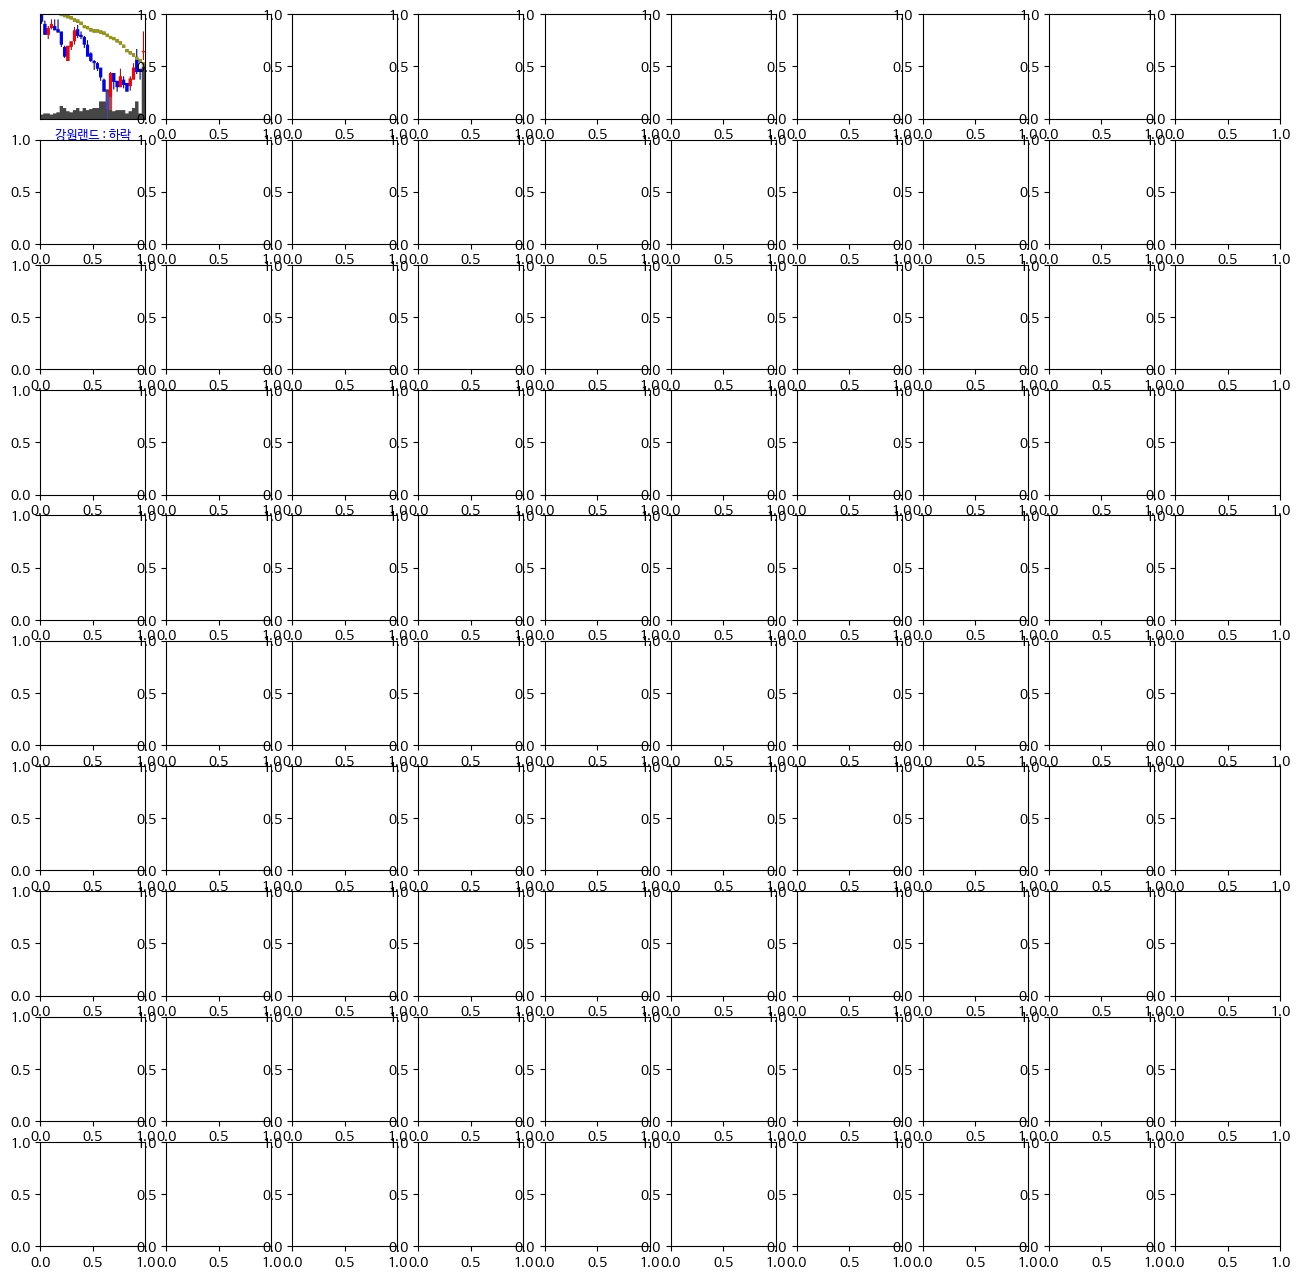

In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime
plt.rc('font', family='NanumBarunGothic')

# 현재 날짜를 'x월 x일' 형식으로 변환합니다.
today = datetime.now().strftime("%m월 %d일")

fig, axes = plt.subplots(10, 10, figsize=(16, 16))
for i in range(10):
    for j in range(10):
        img_idx = i * 10 + j
        img = Image.fromarray(test_images[img_idx])
        axes[i, j].imshow(img)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])
        # 색상 변경을 위해 text 함수를 사용합니다.
        color = 'red' if predicted_labels[i*10 + j] else 'blue'
        text = f'{stock_codes[i*10 + j][1]} : {"상승" if predicted_labels[i*10 + j] else "하락"}'
        axes[i, j].text(0.5, -0.15, text, fontsize=9, color=color, ha='center', va='center', transform=axes[i, j].transAxes)

# 제목 추가 (날짜 포함)
plt.suptitle(f'{today} 종가대비 향후 5거래일 평균 가격 예상', fontsize=20, y=0.95)

plt.subplots_adjust(wspace=0.1, hspace=0.3)
plt.show()


In [ ]:
a = fdr.DataReader('035250')
print(a.tail())

             Open   High    Low  Close   Volume    Change
Date                                                     
2023-08-04  15640  15910  15520  15840   526457  0.022595
2023-08-07  15840  16300  15840  16160   818666  0.020202
2023-08-08  16390  16740  15990  16070  1248098 -0.005569
2023-08-09  16140  16140  15830  16070   410114  0.000000
2023-08-10  16680  17270  16450  16680  3594068  0.037959
